In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import geopandas as gpd
sys.path.append("../../../")
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../dataset/pm.csv")

In [3]:
df.head()

,Date,Source,Site ID,POC,Daily Mean PM10 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/11/1990,AQS,120111003,1,45,ug/m3 SC,42,NaN,1,100.0,81102,PM10 Total 0-10um STP,33100.0,"Miami-Fort Lauderdale-West Palm Beach, FL",12,Florida,11,Broward,26.129531,-80.168379
1,01/17/1990,AQS,120111003,1,21,ug/m3 SC,19,NaN,1,100.0,81102,PM10 Total 0-10um STP,33100.0,"Miami-Fort Lauderdale-West Palm Beach, FL",12,Florida,11,Broward,26.129531,-80.168379
2,01/23/1990,AQS,120111003,1,26,ug/m3 SC,24,NaN,1,100.0,81102,PM10 Total 0-10um STP,33100.0,"Miami-Fort Lauderdale-West Palm Beach, FL",12,Florida,11,Broward,26.129531,-80.168379
3,01/29/1990,AQS,120111003,1,26,ug/m3 SC,24,NaN,1,100.0,81102,PM10 Total 0-10um STP,33100.0,"Miami-Fort Lauderdale-West Palm Beach, FL",12,Florida,11,Broward,26.129531,-80.168379
4,02/04/1990,AQS,120111003,1,19,ug/m3 SC,18,NaN,1,100.0,81102,PM10 Total 0-10um STP,33100.0,"Miami-Fort Lauderdale-West Palm Beach, FL",12,Florida,11,Broward,26.129531,-80.168379


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
centroids = np.load("USA_Centroids.npy")

In [6]:
tdf = df.drop(columns=[ 'Source', 
       'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'DAILY_OBS_COUNT',
        'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC',
        'CBSA_CODE','CBSA_NAME', 'POC'
                ])

In [7]:
tdf.head()

,Date,Site ID,Daily Mean PM10 Concentration,PERCENT_COMPLETE,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/11/1990,120111003,45,100.0,12,Florida,11,Broward,26.129531,-80.168379
1,01/17/1990,120111003,21,100.0,12,Florida,11,Broward,26.129531,-80.168379
2,01/23/1990,120111003,26,100.0,12,Florida,11,Broward,26.129531,-80.168379
3,01/29/1990,120111003,26,100.0,12,Florida,11,Broward,26.129531,-80.168379
4,02/04/1990,120111003,19,100.0,12,Florida,11,Broward,26.129531,-80.168379


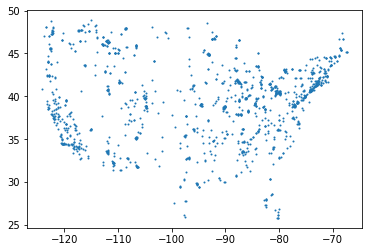

In [8]:
tdf = tdf[tdf['STATE']!='Hawaii']
tdf = tdf[tdf['STATE']!='Alaska']

plt.scatter(tdf['SITE_LONGITUDE'].unique(), tdf['SITE_LATITUDE'].unique(), s = 1)
plt.show()

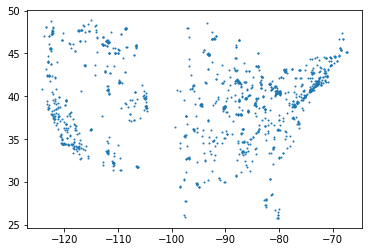

In [9]:
t1 = pd.concat([tdf[tdf['SITE_LONGITUDE']<-104.01], tdf[tdf['SITE_LONGITUDE']>-99.42]])
t1 = t1[t1['STATE']!='New Mexico']
# t1 = t1[t1['STATE']!='Arizona']
plt.scatter(t1['SITE_LONGITUDE'].unique(), t1['SITE_LATITUDE'].unique(), s = 1)
plt.show()

In [10]:
t2 = t1.copy()

In [11]:
states = t1['STATE'].unique()
nw = ['Washington', 'Oregon', 'Wyoming','Idaho', 'Montana', 'Colorado','Utah','Nevada']
sc = ['California']
mw = ['West Virginia', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']
se = ['Oklahoma','Florida', 'Alabama', 'Georgia',  'Tennessee', 'South Carolina', 'North Carolina', 'Virginia', 'Louisiana', 'Arkansas', 'Texas', 'Kentucky']
ne = ['Connecticut',
 'Delaware',
 'Maine',
 'Maryland',
 'Massachusetts',
 'New Hampshire',
 'New Jersey',
 'New York',
 'Pennsylvania',
 'Rhode Island',
 'Vermont','District Of Columbia'
]


In [12]:
nwdf = t1[np.isin(t1['STATE'], nw)]
mwdf = t1[np.isin(t1['STATE'], mw)]
sedf = t1[np.isin(t1['STATE'], se)]
nedf = t1[np.isin(t1['STATE'], ne)]
cal = t1[np.isin(t1['STATE'], ['California'])]
ncal = cal[cal['SITE_LATITUDE']>=34.81]
scal = cal[cal['SITE_LATITUDE']<34.81]
# nwdf = pd.concat([nwdf, t1[t1[np.isin(t1['STATE'], ['California'])]]['SITE_LATITUDE']>34.81])

nwdf = pd.concat([nwdf, ncal])

## DATA VALIDATION



In [13]:
def func_select_11(df):
    t = df.groupby(['Date', 'Site ID', 'STATE', 'COUNTY_CODE','COUNTY']).mean()
    t = t.reset_index(None)
    t1 = t.groupby('Site ID').count()
    t11 = t.set_index(['Site ID'])
    t11 = t11[t1['Date']>11]
    t11 = t11.reset_index(None)
    return t11

## Annual Interpolations First

## Kriging, done per region; others using the earlier setting.

In [14]:
t1 = t1.groupby('Site ID').mean()
t1 = t1.reset_index()

In [15]:
X = t1[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = t1[['Daily Mean PM10 Concentration']].values

In [16]:
t1.describe()

,Site ID,Daily Mean PM10 Concentration,PERCENT_COMPLETE,STATE_CODE,COUNTY_CODE,SITE_LATITUDE,SITE_LONGITUDE
count,1.274000e+03,1274.000000,1274.0,1274.000000,1274.000000,1274.000000,1274.000000
mean,2.656871e+08,28.943658,100.0,26.490581,78.054160,39.630435,-93.767838
std,1.580209e+08,11.524225,0.0,15.781013,103.015345,4.581312,16.893547
min,1.015000e+07,3.333333,100.0,1.000000,1.000000,25.794222,-124.162100
25%,1.000323e+08,22.391667,100.0,10.000000,19.500000,36.558985,-110.833607
50%,2.703702e+08,27.299806,100.0,27.000000,55.000000,40.069049,-88.133548
75%,3.914200e+08,33.634208,100.0,39.000000,98.500000,42.638166,-79.992582
max,5.603900e+08,144.666667,100.0,56.000000,840.000000,48.879323,-67.396792


### Spatial Interpolation

In [17]:
from polire.interpolate import SpatialAverage
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)

SpatialAverage

In [19]:
annual_spatial_predictions = np.zeros(centroids.shape[0])

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        annual_spatial_predictions[ix: ix + 1000] = spatial.predict(centroids[ix:ix + 1000]).reshape(1000, )
    
    else: 
        annual_spatial_predictions[ix: ] = spatial.predict(centroids[ix:])

### IDW

In [20]:
from polire.interpolate import Idw
from polire.utils.distance import haversine, euclidean
idw = Idw(coordinate_type='Geographic')
idw.fit(X, y)

annual_idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    annual_idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

# $k$-NN


In [21]:
from polire.custom import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor
knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
annual_knn_predictions = knn.predict(centroids)

# Kriging

In [22]:
from polire.interpolate import Kriging

In [23]:
annual_krig_predictions = np.zeros(centroids.shape[0])
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X, y)

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        annual_krig_predictions[ix: ix + 1000] = krig.predict(centroids[ix:ix + 1000])
    
    else: 
        annual_krig_predictions[ix: ] = krig.predict(centroids[ix:])


## Per Quarter

# Q1

In [24]:
t2.head()

,Date,Site ID,Daily Mean PM10 Concentration,PERCENT_COMPLETE,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
16325,01/05/1990,560010006,34,100.0,56,Wyoming,1,Albany,41.311586,-105.591725
16326,01/11/1990,560010006,18,100.0,56,Wyoming,1,Albany,41.311586,-105.591725
16327,01/23/1990,560010006,14,100.0,56,Wyoming,1,Albany,41.311586,-105.591725
16328,02/10/1990,560010006,12,100.0,56,Wyoming,1,Albany,41.311586,-105.591725
16329,02/28/1990,560010006,39,100.0,56,Wyoming,1,Albany,41.311586,-105.591725


In [25]:
q1 = t2[t2['Date']<='03/31/1990']
q1 = func_select_11(q1)
q1.drop(columns=['STATE', 'COUNTY_CODE', 'COUNTY', 'PERCENT_COMPLETE'], inplace=True)
q1 = q1.groupby('Site ID').mean()
X = q1[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = q1[['Daily Mean PM10 Concentration']].values

## Spatial Averaging

In [26]:
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)

SpatialAverage

In [27]:
q1_spatial_predictions = np.zeros(centroids.shape[0])

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q1_spatial_predictions[ix: ix + 1000] = spatial.predict(centroids[ix:ix + 1000]).reshape(1000, )
    
    else: 
        q1_spatial_predictions[ix: ] = spatial.predict(centroids[ix:])

## IDW

In [28]:
idw = Idw(coordinate_type='Geographic')
idw.fit(X, y)
q1_idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    q1_idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

### $k$-NN, with $k = 1$.

In [29]:
knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
q1_knn_predictions = knn.predict(centroids)

In [30]:
q1_krig_predictions = np.zeros(centroids.shape[0])
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X, y)

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q1_krig_predictions[ix: ix + 1000] = krig.predict(centroids[ix:ix + 1000])
    
    else: 
        q1_krig_predictions[ix: ] = krig.predict(centroids[ix:])


# Q2

In [31]:
q2 = t2[(t2['Date']>='04/01/1990').values & (t2['Date']<='06/30/1990').values]
q2 = func_select_11(q2)
q2.drop(columns=['STATE', 'COUNTY_CODE', 'COUNTY', 'PERCENT_COMPLETE'], inplace=True)
q2 = q2.groupby('Site ID').mean()
X = q2[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = q2[['Daily Mean PM10 Concentration']].values

## Spatial

In [32]:
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)

q2_spatial_predictions = np.zeros(centroids.shape[0])

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q2_spatial_predictions[ix: ix + 1000] = spatial.predict(centroids[ix:ix + 1000]).reshape(1000, )
    
    else: 
        q2_spatial_predictions[ix: ] = spatial.predict(centroids[ix:])

## IDW

In [33]:
idw = Idw(coordinate_type='Geographic')
idw.fit(X, y)
q2_idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    q2_idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

## 1NN

In [34]:
knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
q2_knn_predictions = knn.predict(centroids)

In [35]:
q2_krig_predictions = np.zeros(centroids.shape[0])
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X, y)

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q2_krig_predictions[ix: ix + 1000] = krig.predict(centroids[ix:ix + 1000])
    
    else: 
        q2_krig_predictions[ix: ] = krig.predict(centroids[ix:])


# Q3

In [37]:
q3 = t2[(t2['Date']>='07/01/1990').values & (t2['Date']<='09/30/1990').values]
q3 = func_select_11(q3)
q3.drop(columns=['STATE', 'COUNTY_CODE', 'COUNTY', 'PERCENT_COMPLETE'], inplace=True)
q3 = q3.groupby('Site ID').mean()
X = q3[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = q3[['Daily Mean PM10 Concentration']].values


spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)

q3_spatial_predictions = np.zeros(centroids.shape[0])

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q3_spatial_predictions[ix: ix + 1000] = spatial.predict(centroids[ix:ix + 1000]).reshape(1000, )
    
    else: 
        q3_spatial_predictions[ix: ] = spatial.predict(centroids[ix:])
        
idw = Idw(coordinate_type='Geographic')
idw.fit(X, y)
q3_idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    q3_idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))       

knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
q3_knn_predictions = knn.predict(centroids)

q3_krig_predictions = np.zeros(centroids.shape[0])
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X, y)
for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q3_krig_predictions[ix: ix + 1000] = krig.predict(centroids[ix:ix + 1000])
    
    else: 
        q3_krig_predictions[ix: ] = krig.predict(centroids[ix:])


# Q4

In [38]:
q4 = t2[(t2['Date']>='10/01/1990').values ]
q4 = func_select_11(q4)
q4.drop(columns=['STATE', 'COUNTY_CODE', 'COUNTY', 'PERCENT_COMPLETE'], inplace=True)
q4 = q4.groupby('Site ID').mean()
X = q4[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = q4[['Daily Mean PM10 Concentration']].values


spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)

q4_spatial_predictions = np.zeros(centroids.shape[0])

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q4_spatial_predictions[ix: ix + 1000] = spatial.predict(centroids[ix:ix + 1000]).reshape(1000, )
    
    else: 
        q4_spatial_predictions[ix: ] = spatial.predict(centroids[ix:])
        
idw = Idw(coordinate_type='Geographic')
idw.fit(X, y)
q4_idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    q4_idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))       

knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)

q4_knn_predictions = knn.predict(centroids)


q4_krig_predictions = np.zeros(centroids.shape[0])
krig = Kriging(variogram_model='spherical', coordinate_type='Geographic')
krig.fit(X, y)
for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        q4_krig_predictions[ix: ix + 1000] = krig.predict(centroids[ix:ix + 1000])
    
    else: 
        q4_krig_predictions[ix: ] = krig.predict(centroids[ix:])


In [39]:
from scipy.stats import pearsonr

ANNUAL

In [40]:
pearsonr(annual_idw_predictions, annual_krig_predictions), 

((0.8676398793998185, 0.0),)

In [41]:
pearsonr(annual_idw_predictions, annual_knn_predictions.reshape(-1, )),

((0.873904360729131, 0.0),)

In [42]:
pearsonr(annual_krig_predictions, annual_knn_predictions.reshape(-1, ))

(0.7291435559742303, 0.0)

In [43]:
mask = ~np.isnan(annual_spatial_predictions)

In [44]:
pearsonr(annual_idw_predictions[mask], annual_spatial_predictions[mask])

(0.9490029145269329, 0.0)

In [45]:
pearsonr(annual_knn_predictions.reshape(-1, )[mask], annual_spatial_predictions[mask])

(0.9066252921085345, 0.0)

In [46]:
pearsonr(annual_krig_predictions.reshape(-1, )[mask], annual_spatial_predictions[mask])

(0.8287710862153234, 0.0)

In [47]:
pearsonr(q3_idw_predictions, q3_krig_predictions), 

((0.8995078496084847, 0.0),)

In [48]:
pearsonr(q3_idw_predictions, q3_knn_predictions.reshape(-1, )),

((0.8780658163368463, 0.0),)

In [49]:
pearsonr(q3_krig_predictions, q3_knn_predictions.reshape(-1, ))

(0.7884358798913053, 0.0)

In [50]:
mask = ~np.isnan(q3_spatial_predictions)

In [51]:
pearsonr(q3_idw_predictions[mask], q3_spatial_predictions[mask])

(0.957193084501417, 0.0)

In [52]:
pearsonr(q3_knn_predictions.reshape(-1, )[mask], q3_spatial_predictions[mask])

(0.9360371397627134, 0.0)

In [53]:
pearsonr(q3_krig_predictions.reshape(-1, )[mask], q3_spatial_predictions[mask])

(0.850846836750555, 0.0)

## Annual Range of Estimates

In [54]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [55]:
annual_knn_predictions = annual_knn_predictions.reshape(-1, )
annual_idw_predictions = annual_idw_predictions.reshape(-1, )
annual_spatial_predictions = annual_spatial_predictions.reshape(-1, )
annual_krig_predictions = annual_krig_predictions.reshape(-1, )

In [56]:
temp = []
for ix in range(annual_knn_predictions.shape[0]):
    temp.append([
                    annual_krig_predictions[ix], annual_knn_predictions[ix], annual_idw_predictions[ix], annual_spatial_predictions[ix]
                ])

In [57]:
hist = []
for ix, _ in enumerate(temp):
    mask = ~np.isnan(temp[ix])
    if mask.sum() < 4:
        if mask.sum() >= 2:
            temp2 = np.array(temp[ix])[mask]
            maximum_value = np.max(temp2)
            minimum_value = np.min(temp2)
            hist.append(maximum_value - minimum_value)
        
    if mask.sum() == 4:
        maximum_value = np.max(temp[ix])
        minimum_value = np.min(temp[ix])
        hist.append(maximum_value - minimum_value)

In [58]:
len(hist), (np.array(hist)<7).sum(), (np.array(hist)<15).sum()

(215891, 161328, 205578)

In [61]:
from sklearn.neighbors import KernelDensity

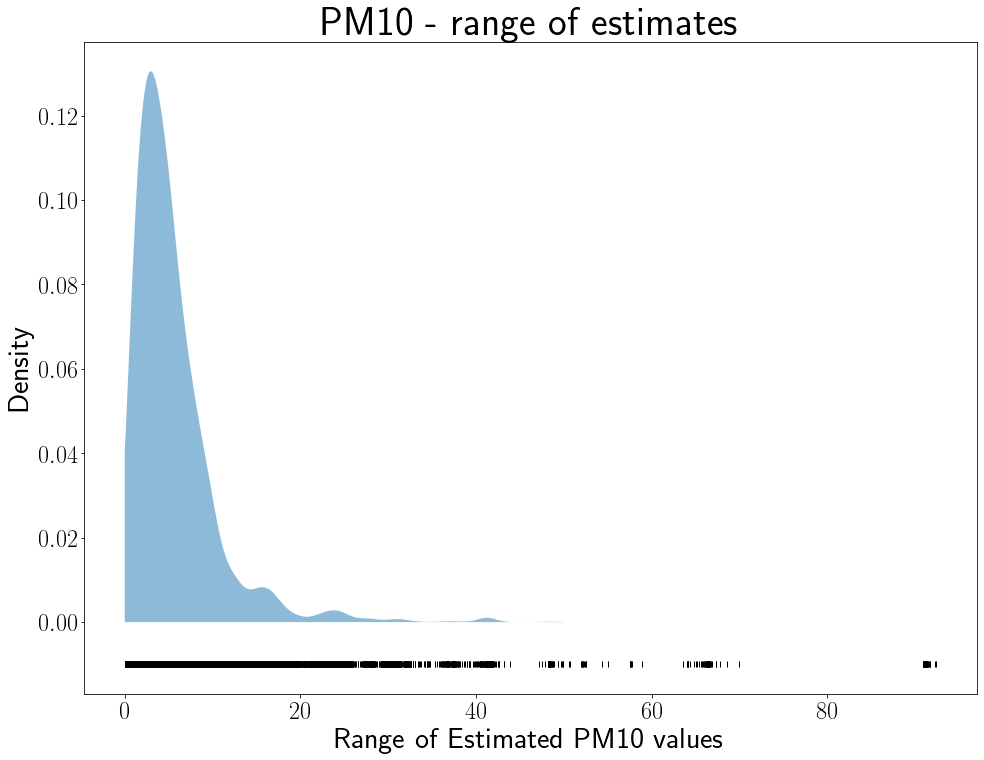

In [62]:
fig = plt.figure(figsize=(16, 12))

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(np.array(hist)[:, None])

x_d = np.linspace(0, 50, 1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(np.array(hist), np.full_like(np.array(hist), -0.01), '|k', markeredgewidth=1)
# plt.ylim(-0.02, 0.22)

plt.title("PM10 - range of estimates", fontsize=40)
plt.xlabel("Range of Estimated PM10 values", fontsize=30)
plt.ylabel("Density",fontsize = 30)
plt.tick_params(axis='both', labelsize=24)

## Q3 Range of Estimates

In [63]:
q3_knn_predictions = q3_knn_predictions.reshape(-1, )
q3_idw_predictions = q3_idw_predictions.reshape(-1, )
q3_spatial_predictions = q3_spatial_predictions.reshape(-1, )
q3_krig_predictions = q3_krig_predictions.reshape(-1, )

temp = []
for ix in range(q3_knn_predictions.shape[0]):
    temp.append([
                    q3_krig_predictions[ix], q3_knn_predictions[ix], q3_idw_predictions[ix], q3_spatial_predictions[ix]
                ])

hist = []
for ix, _ in enumerate(temp):
    mask = ~np.isnan(temp[ix])
    if mask.sum() < 4:
        if mask.sum() >= 2:
            temp2 = np.array(temp[ix])[mask]
            maximum_value = np.max(temp2)
            minimum_value = np.min(temp2)
            hist.append(maximum_value - minimum_value)
        
    if mask.sum() == 4:
        maximum_value = np.max(temp[ix])
        minimum_value = np.min(temp[ix])
        hist.append(maximum_value - minimum_value)

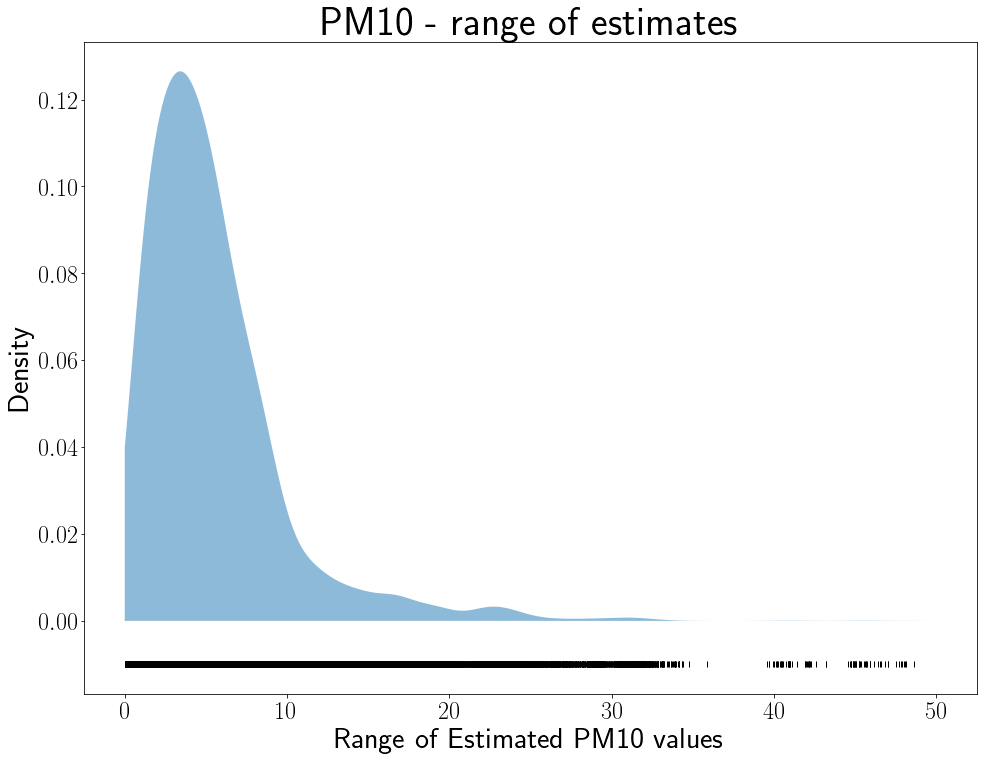

In [64]:
fig = plt.figure(figsize=(16, 12))

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(np.array(hist)[:, None])

x_d = np.linspace(0, 50, 1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(np.array(hist), np.full_like(np.array(hist), -0.01), '|k', markeredgewidth=1)
# plt.ylim(-0.02, 0.22)

plt.title("PM10 - range of estimates", fontsize=40)
plt.xlabel("Range of Estimated PM10 values", fontsize=30)
plt.ylabel("Density",fontsize = 30)
plt.tick_params(axis='both', labelsize=24)